In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.patches as patches  
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list
import scipy.sparse as sp
import math

In [2]:
def load_dist_df(data):
    matrix = sp.csr_matrix((data["data"], data["indices"], data["indptr"]), shape=data["shape"])
    dense_matrix = matrix.toarray()
    df = pd.DataFrame(dense_matrix)
    return df

import math
def series_to_matrix(s: pd.Series, diagonal_included: bool = True) -> np.ndarray:
    """
    Convert a Series of upper-triangle matrix values into a full symmetric 2D NumPy array.

    Parameters:
      s (pd.Series): The input series containing the values.
      diagonal_included (bool): 
         - True if the series includes the diagonal values (upper triangle with diagonal).
         - False if it only includes the strictly upper triangle (diagonal is omitted).

    Returns:
      np.ndarray: The full symmetric matrix.
    """
    M = len(s)
    
    # Determine the dimension of the matrix (n x n)
    if diagonal_included:
        # For upper triangle with diagonal: M = n*(n+1)/2
        n = int((-1 + math.sqrt(1 + 8 * M)) / 2)
    else:
        # For strictly upper triangle: M = n*(n-1)/2
        n = int((1 + math.sqrt(1 + 8 * M)) / 2)
    
    # Create an empty n x n matrix filled with NaN.
    matrix = np.full((n, n), np.nan)
    
    k = 0  # Series index
    if diagonal_included:
        # Fill the upper triangle including the diagonal (i <= j)
        for i in range(n):
            for j in range(i, n):
                if k < M:
                    matrix[i, j] = s.iloc[k]
                    k += 1
                else:
                    break
    else:
        # Fill the strictly upper triangle (i < j)
        for i in range(n):
            for j in range(i + 1, n):
                if k < M:
                    matrix[i, j] = s.iloc[k]
                    k += 1
                else:
                    break
                    
    # Mirror the upper triangle to the lower triangle to make the matrix symmetric.
    for i in range(n):
        for j in range(i):
            matrix[i, j] = matrix[j, i]
            
    # If the series did not include the diagonal and a value is needed for it, you can set it here.
    if not diagonal_included:
        np.fill_diagonal(matrix, 0)  # Change to any preferred value if needed

    return matrix

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


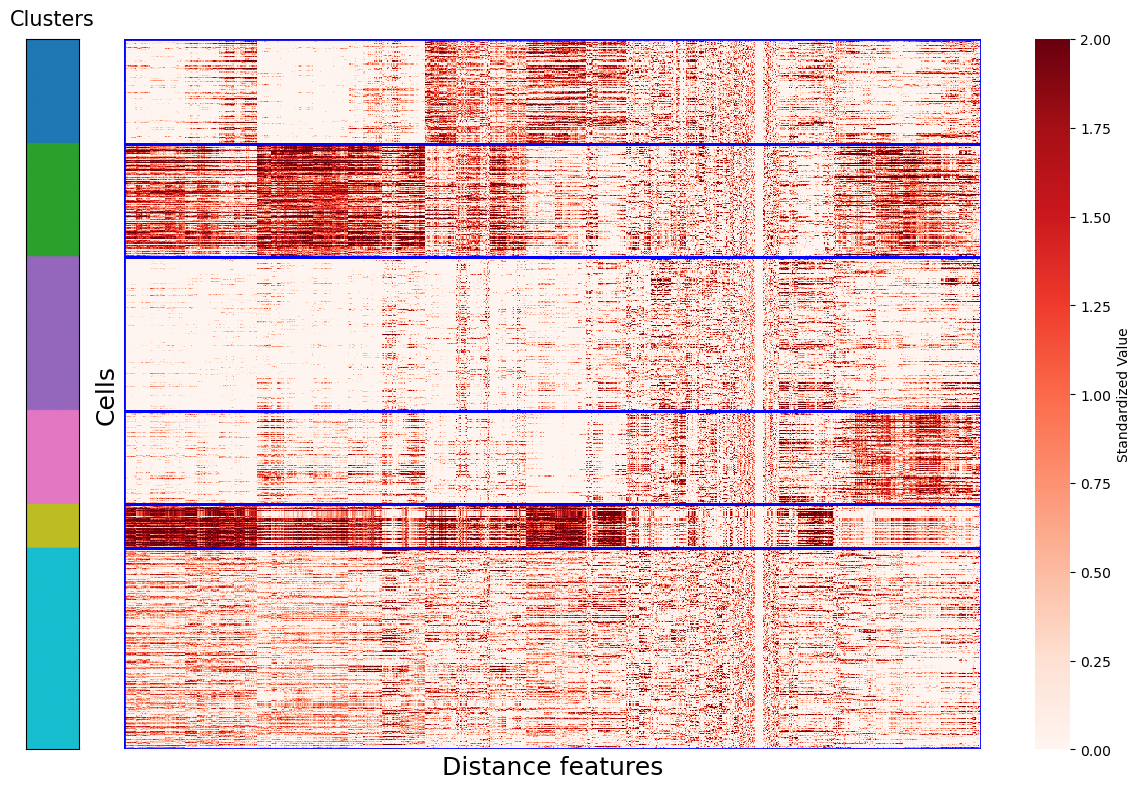

In [4]:
# ---------------------------
# 1. Load Example distance matrix Data, downloaded from the database
# ---------------------------
data_IMR = np.load('../example_data/IMR_chr8_127300000_128300000.npz')
data_IMR_df = load_dist_df(data_IMR)
df_features = data_IMR_df

# ---------------------------
# 2. Standardize the Features 
# ---------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(X_scaled, columns=df_features.columns)

# ---------------------------
# 3. Cluster the Rows Using K-Means
# ---------------------------
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(df_scaled)
df_scaled['cluster'] = clusters

# ---------------------------
# 4. Sort Rows by Cluster Assignment
# ---------------------------
df_sorted = df_scaled.sort_values('cluster')
data_for_heatmap = df_sorted.drop('cluster', axis=1)

# ---------------------------
# 5. Cluster the Columns (Features) Using Hierarchical Clustering
# ---------------------------
# Compute pairwise distances among columns (transpose the data)
col_distance = pdist(data_for_heatmap.T, metric='euclidean')
Z_cols = linkage(col_distance, method='ward')
col_leaves = leaves_list(Z_cols)

# Reorder columns based on hierarchical clustering results
reordered_columns = data_for_heatmap.columns[col_leaves]
data_for_heatmap = data_for_heatmap[reordered_columns]

# ---------------------------
# 6. Create the Left Cluster Bar
# ---------------------------
# Create a discrete colormap for clusters using 'tab10'
unique_clusters = np.unique(df_sorted['cluster'].values)
num_unique = len(unique_clusters)
cmap = plt.get_cmap('tab10', num_unique)

# Create an array of RGBA colors for each row based on its cluster label
row_colors = np.array([cmap(label) for label in df_sorted['cluster'].values]).reshape(-1, 1, 4)

# ---------------------------
# 7. Plot the Heatmap with the Left Cluster Bar
# ---------------------------
# Create a figure with two axes:
#   - Left narrow axis for the cluster bar.
#   - Right wide axis for the heatmap.
fig, (ax_cluster, ax_heatmap) = plt.subplots(
    ncols=2, 
    gridspec_kw={'width_ratios': [0.05, 1]}, 
    figsize=(12, 8)
)

# Plot the left cluster bar
ax_cluster.imshow(row_colors, aspect='auto')
ax_cluster.set_xticks([])
ax_cluster.set_yticks([])
ax_cluster.set_title("Clusters", fontsize=15, pad=10)

# Plot the heatmap using seaborn on the right axis
sns.heatmap(
    data_for_heatmap,
    cmap='Reds',
    vmax=2,
    vmin=0,
    cbar_kws={'label': 'Standardized Value'},
    xticklabels=True,  # tick labels will be hidden next
    yticklabels=False,
    ax=ax_heatmap
)
ax_heatmap.set_title("", fontsize=18)
ax_heatmap.set_xlabel("Distance features",fontsize=18)  # Remove x-axis label
ax_heatmap.set_xticks([])  # Remove x-axis ticks
ax_heatmap.set_ylabel("Cells",fontsize=18)


# ---------------------------
# 8. Draw Bounding Boxes Around the Row Clusters
# ---------------------------
cluster_boundaries = []
current_cluster = None
start_idx = None

for i, row in enumerate(df_sorted.itertuples()):
    label = row.cluster
    if label != current_cluster:
        if current_cluster is not None:
            cluster_boundaries.append((current_cluster, start_idx, i - 1))
        current_cluster = label
        start_idx = i
# Handle the last cluster
cluster_boundaries.append((current_cluster, start_idx, len(df_sorted) - 1))

# Draw a bounding box for each cluster on the heatmap
num_features = data_for_heatmap.shape[1]
for clus, start, end in cluster_boundaries:
    height = end - start + 1
    rect = patches.Rectangle(
        (0, start),         # Lower-left corner of the box (x=0, y=start index)
        num_features,       # Width spans all columns
        height,             # Height equals number of rows in the cluster
        fill=False,
        edgecolor='blue',
        linewidth=2
    )
    ax_heatmap.add_patch(rect)

plt.tight_layout()
plt.show()

Cluster: 0


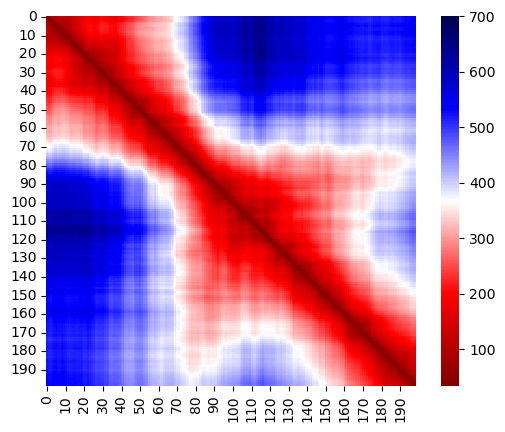

Cluster: 1


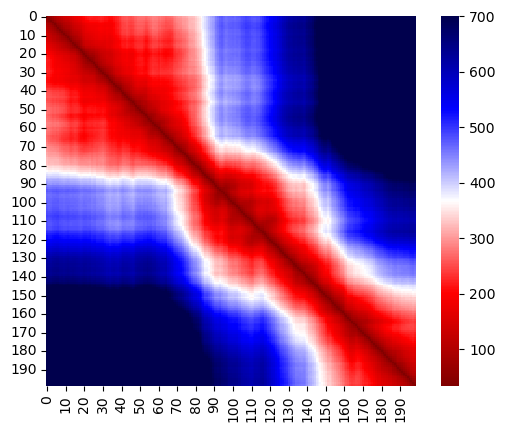

Cluster: 2


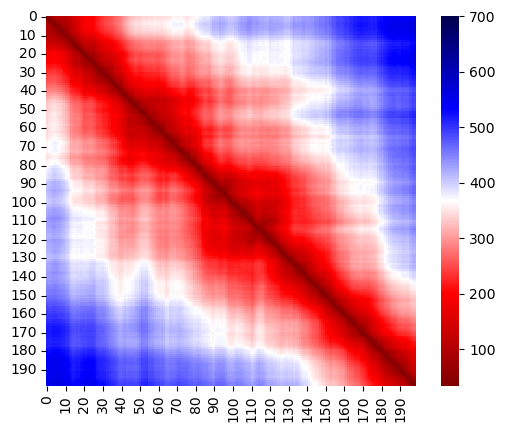

Cluster: 3


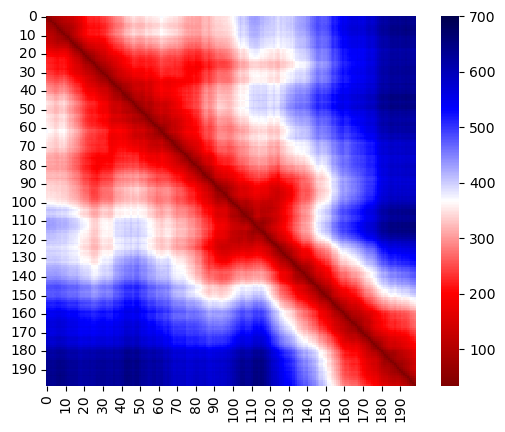

Cluster: 4


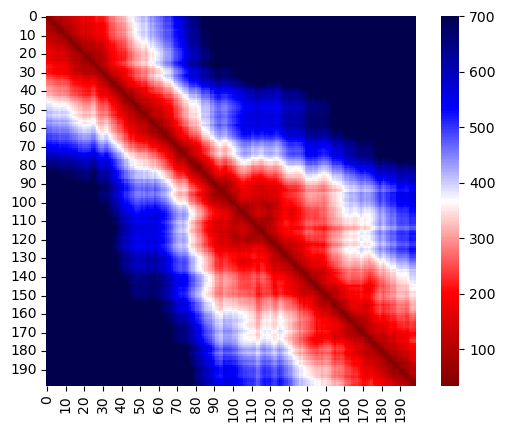

Cluster: 5


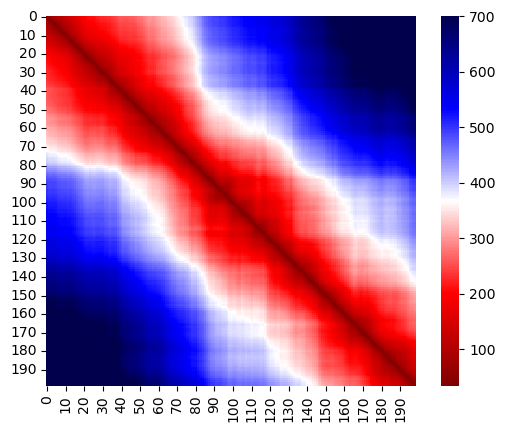

In [5]:
## plot the average distance heatmap of each cluster
df_features['cluster'] = clusters
# plot the average distance heatmap of each cluster
for i in range(n_clusters):
    print('Cluster:',i)
    sns.heatmap(series_to_matrix(df_features[df_features['cluster']==i].iloc[:,:-1].mean()),cmap = 'seismic_r', vmax=700, square=True , xticklabels = 10,yticklabels = 10)
    plt.show()

In [6]:
## Number of structures in each cluster
df_features.groupby('cluster').count().iloc[:,1]

cluster
0     739
1     796
2    1081
3     660
4     308
5    1416
Name: 1, dtype: int64